In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import torch
from kan import *
from kan.utils import create_dataset_from_data, ex_round

In [101]:
# Список функций
def f1(x):
    """f(x) = sin(pi * x) + x^2"""
    return np.sin(np.pi * x) + x**2

def f2(x):
    """f(x) = exp(-x^2)"""
    return np.exp(-x**2)

def f3(x):
    """f(x) = x * sin(5 * x)"""
    return x * np.sin(5 * x)

def f4(x):
    """f(x, y) = sin(pi * x) + y^2"""
    return np.sin(np.pi * x[:, 0]) + x[:, 1]**2

def f5(x):
    """f(x, y) = exp(sin(pi * x) + y^2) — как в hellokan"""
    return np.exp(np.sin(np.pi * x[:, 0]) + x[:, 1]**2)

FUNCTIONS = [
    (f1, 1, "sin(pi*x) + x^2", "D1N1"),
    (f2, 1, "exp(-x^2)", "D1N2"),
    (f3, 1, "x * sin(5*x)", "D1N3"),
    (f4, 2, "sin(pi*x) + y^2", "D2N1"),
    (f5, 2, "exp(sin(pi*x) + y^2)", "D2N1"),
]

In [ ]:
base_name = f"data_{clean_id}_noise{noise_level}_{gap_str}_n{n_samples}"

In [ ]:
columns = ['func_id', 'noise_level', 'gap_str', 'n_samples', 'width', 'k', 'grid',
'loss_train_history_before',
'loss_test_history_before',
'reg_history_before',
'test_residuals_defore_prune',
'test_mse_defore_prune',
'test_mae_defore_prune',
'test_r2_defore_prune',
'true_residuals_defore_prune',
'true_mse_defore_prune',
'true_mae_defore_prune',
'true_r2_defore_prune',

'loss_train_history_after_prune',
'loss_test_history_after_prune',
'reg_history_after_prune',
'test_residuals_after_prune', 
'test_mse_after_prune',
'test_mae_after_prune',
'test_r2_after_prune',
'true_residuals_after_prune',
'true_mse_after_prune',
'true_mae_after_prune',
'true_r2_after_prune',

'loss_train_history_after_refine',
'loss_test_history_after_refine',
'reg_history_after_refine',
'test_residuals_after_refine', 
'test_mse_after_refine',
'test_mae_after_refine',
'test_r2_after_refine',
'true_residuals_after_refine',
'true_mse_after_refine',
'true_mae_after_refine',
'true_r2_after_refine',

'loss_train_history_after_symbolic',
'loss_test_history_after_symbolic',
'reg_history_after_symbolic',
'test_residuals_after_symbolic', 
'test_mse_after_symbolic',
'test_mae_after_symbolic',
'test_r2_after_symbolic',
'true_residuals_after_symbolic',
'true_mse_after_symbolic',
'true_mae_after_symbolic',
'true_r2_after_symbolic',

'formula'
]

In [7]:
func_indices = list(range(len(FUNCTIONS)))          # [0, 1, 2, 3, 4]
n_samples_list = [100, 200, 400, 500]
noise_levels = [0,0.05,0.1,0.3,0.5]           # 0.0, 0.05, ..., 0.5
gap_ranges = [None, [-1, 1], [0.5, 1]]              # включая "без пропуска"
path = "./datasets"

In [126]:
def stats( model, dataset, func, n_var, x_true ):
    # Предсказание модели на новых данных (например, test_input)
    x_true_clear = x_true.copy()
    if n_var==2:
        x_true_clear = np.column_stack([x_true, x_true])
    
    y_true_clear = func(x_true_clear)
    
    with torch.no_grad():
        y_pred = model(dataset['test_input'])  # shape: (N_test, 1)
        y_true = dataset['test_label']         # shape: (N_test, 1)
        y_true_pred = model( torch.tensor(x_true_clear, dtype=torch.float32, device='cpu').reshape( (len(x_true), n_var) ) ) 
    # Преобразуем в numpy для удобства (опционально)
    y_pred_np = y_pred.cpu().numpy().flatten()
    y_true_np = y_true.cpu().numpy().flatten()
    y_true_pred = y_true_pred.cpu().numpy().flatten()
    # Остатки (residuals)
    residuals = y_true_np - y_pred_np
    # MSE — среднеквадратичная ошибка
    mse = np.mean(residuals ** 2)
    # MAE — средняя абсолютная ошибка
    mae = np.mean(np.abs(residuals))
    ss_res_test = np.sum(residuals ** 2)
    ss_tot_test = np.sum((y_true_np - np.mean(y_true_np)) ** 2)
    r2 = 1 - (ss_res_test / ss_tot_test)
    

    residuals_true = y_true_clear - y_true_pred
    # MSE — среднеквадратичная ошибка
    mse_true = np.mean(residuals_true ** 2)
    # MAE — средняя абсолютная ошибка
    mae_true = np.mean(np.abs(residuals_true))
    ss_res_true = np.sum(residuals_true ** 2)
    ss_tot_true = np.sum((y_true_clear - np.mean(y_true_clear)) ** 2)
    r2_true = 1 - (ss_res_true / ss_tot_true)

    # return residuals, mse, mae, residuals_true, mse_true, mae_true
    return {
            'test_residuals': residuals,
            'test_mse': mse,
            'test_mae': mae,
            'test_r2': r2,
            'true_residuals': residuals_true,
            'true_mse': mse_true,
            'true_mae': mae_true,
            'true_r2': r2_true
        }

In [ ]:
x_true = np.linspace(-2,2,500)
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
width_list = [  
    [ 5, 1],
    [ 4, 4, 4, 1],
    [ 15, 1],
    [ 5, 5, 1],
    [ 10, 6, 3, 1]
]
k_list = [3, 5]
grid_list = [3,4,5]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
counter = 0
for func_idx in func_indices:
    for gap_range in gap_ranges:
        for n_samples in n_samples_list:
            for noise_level in noise_levels:
                for width in width_list:
                    for k in k_list:
                        for grid in grid_list:
                            #print(f'data_{id_name}_noise{noise_level}_{gap_str}_n{n_samples}.csv')
                            gap_str = f"gap{gap_range[0]}_{gap_range[1]}" if gap_range else "nogap"
                            func, n_var, name, id_name = FUNCTIONS[func_idx]
                            width_current = [n_var] + width
                            counter += 1
                            df = pd.read_csv( f'datasets/data_{id_name}_noise{noise_level}_{gap_str}_n{n_samples}.csv', index_col=False )
                            print(f'{len(df)=}')
                            if n_var==1:
                                x = torch.tensor( df['x1'], dtype=torch.float32)
                            else:
                                x = torch.tensor(df[['x1', 'x2']].values, dtype=torch.float32)
                            x = x.reshape( (len(x), n_var))
                            y = torch.tensor( df['y'], dtype=torch.float32).reshape((len(x), 1) )
                            dataset = create_dataset_from_data(x, y)
                            model = KAN(width=width_current, grid=grid, k=k, seed=42, device=device, auto_save=False)

                            results_before_prune = model.fit(dataset, opt="LBFGS", steps=2, lamb=0.001, update_grid=False)
                            stats_before_prune = stats( model, dataset, func, n_var, x_true )

                            model = model.prune()
                            results_after_prune = model.fit(dataset, opt="LBFGS", steps=2, update_grid=False)
                            stats_after_prune = stats( model, dataset, func, n_var, x_true )

                            model = model.refine(10)
                            results_after_refine = model.fit(dataset, opt="LBFGS", steps=2, update_grid=False)
                            stats_after_refine = stats( model, dataset, func, n_var, x_true )

                            model.auto_symbolic(lib=lib)
                            results_after_symbolic = model.fit(dataset, opt="LBFGS", steps=50, update_grid=False)
                            stats_after_symbolic = stats( model, dataset, func, n_var, x_true )

                            formula = ex_round(model.symbolic_formula()[0][0],4)

                            #print(f'{counter}   \n{dataset['train_input'].shape} {dataset['train_label'].shape}')

                            print()
                

In [118]:
x_true = np.linspace(-2,2,500)
x_true = np.column_stack([x_true, x_true])
print(shape(x_true))
a = torch.tensor(x_true, dtype=torch.float32, device='cpu').reshape( (len(x_true), 2) )
print(shape(a))
a

(500, 2)
torch.Size([500, 2])


tensor([[-2.0000, -2.0000],
        [-1.9920, -1.9920],
        [-1.9840, -1.9840],
        [-1.9760, -1.9760],
        [-1.9679, -1.9679],
        [-1.9599, -1.9599],
        [-1.9519, -1.9519],
        [-1.9439, -1.9439],
        [-1.9359, -1.9359],
        [-1.9279, -1.9279],
        [-1.9198, -1.9198],
        [-1.9118, -1.9118],
        [-1.9038, -1.9038],
        [-1.8958, -1.8958],
        [-1.8878, -1.8878],
        [-1.8798, -1.8798],
        [-1.8717, -1.8717],
        [-1.8637, -1.8637],
        [-1.8557, -1.8557],
        [-1.8477, -1.8477],
        [-1.8397, -1.8397],
        [-1.8317, -1.8317],
        [-1.8236, -1.8236],
        [-1.8156, -1.8156],
        [-1.8076, -1.8076],
        [-1.7996, -1.7996],
        [-1.7916, -1.7916],
        [-1.7836, -1.7836],
        [-1.7756, -1.7756],
        [-1.7675, -1.7675],
        [-1.7595, -1.7595],
        [-1.7515, -1.7515],
        [-1.7435, -1.7435],
        [-1.7355, -1.7355],
        [-1.7275, -1.7275],
        [-1.7194, -1

In [92]:
x_true

array([-2.        , -1.99198397, -1.98396794, -1.9759519 , -1.96793587,
       -1.95991984, -1.95190381, -1.94388778, -1.93587174, -1.92785571,
       -1.91983968, -1.91182365, -1.90380762, -1.89579158, -1.88777555,
       -1.87975952, -1.87174349, -1.86372745, -1.85571142, -1.84769539,
       -1.83967936, -1.83166333, -1.82364729, -1.81563126, -1.80761523,
       -1.7995992 , -1.79158317, -1.78356713, -1.7755511 , -1.76753507,
       -1.75951904, -1.75150301, -1.74348697, -1.73547094, -1.72745491,
       -1.71943888, -1.71142285, -1.70340681, -1.69539078, -1.68737475,
       -1.67935872, -1.67134269, -1.66332665, -1.65531062, -1.64729459,
       -1.63927856, -1.63126253, -1.62324649, -1.61523046, -1.60721443,
       -1.5991984 , -1.59118236, -1.58316633, -1.5751503 , -1.56713427,
       -1.55911824, -1.5511022 , -1.54308617, -1.53507014, -1.52705411,
       -1.51903808, -1.51102204, -1.50300601, -1.49498998, -1.48697395,
       -1.47895792, -1.47094188, -1.46292585, -1.45490982, -1.44

In [ ]:
from kan import *
torch.set_default_dtype(torch.float64)


print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)
results = model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001)

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.21e-02 | test_loss: 2.26e-02 | reg: 5.63e+00 | : 100%|█| 50/50 [00:24<00:00,  2.02it

saving model version 0.1


In [51]:
model = model.prune()
results = model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001, update_grid=False)

saving model version 0.2


| train_loss: 1.76e-02 | test_loss: 1.70e-02 | reg: 7.65e+00 | : 100%|█| 50/50 [00:14<00:00,  3.43it

saving model version 0.3


In [52]:
len(results['reg'])

50

In [54]:
x_true = np.linspace(-2,2,500)
X1, X2 = np.meshgrid(x_true, x_true, indexing='ij')
x_grid = np.column_stack([X1.ravel(), X2.ravel()])
shape(x_grid)

(250000, 2)

In [57]:
x_true = np.linspace(-2,2,500)
x_true = np.column_stack([x_true, x_true])
shape(x_true)

(500, 2)

In [3]:
n_vars = 2
a = [2, 4, 6]
str([n_vars] + a)

'[2, 2, 4, 6]'

In [ ]:
widths = [  
    [ 5, 1],
    [ 4, 4, 4, 1],
    [ 15, 1],
    [ 5, 5, 1],
    [ 10, 6, 3, 1]
]
k_list = [3, 5]
grid_list = [3,4,5]

In [4]:
str(None)

'None'

In [ ]:
base_cols = [
    'func_id', 'noise_level', 'gap_str', 'n_samples',
    'width', 'k', 'grid', 'formula', 'seed'
]
stages = ['before_prune', 'after_prune', 'after_refine', 'after_symbolic']
loss_cols = []
metric_cols = []

for stage in stages:
    loss_cols += [
        f'loss_train_history_{stage}',
        f'loss_test_history_{stage}',
        f'reg_history_{stage}',
    ]
    metric_cols += [
        f'test_residuals_{stage}',
        f'test_mse_{stage}',
        f'test_mae_{stage}',
        f'test_r2_{stage}',
        f'true_residuals_{stage}',
        f'true_mse_{stage}',
        f'true_mae_{stage}',
        f'true_r2_{stage}',
    ]

all_columns = base_cols + loss_cols + metric_cols
all_columns

['func_id',
 'noise_level',
 'gap_str',
 'n_samples',
 'width',
 'k',
 'grid',
 'formula',
 'loss_train_history_before_prune',
 'loss_test_history_before_prune',
 'reg_history_before_prune',
 'loss_train_history_after_prune',
 'loss_test_history_after_prune',
 'reg_history_after_prune',
 'loss_train_history_after_refine',
 'loss_test_history_after_refine',
 'reg_history_after_refine',
 'loss_train_history_after_symbolic',
 'loss_test_history_after_symbolic',
 'reg_history_after_symbolic',
 'test_residuals_before_prune',
 'test_mse_before_prune',
 'test_mae_before_prune',
 'test_r2_before_prune',
 'true_residuals_before_prune',
 'true_mse_before_prune',
 'true_mae_before_prune',
 'true_r2_before_prune',
 'test_residuals_after_prune',
 'test_mse_after_prune',
 'test_mae_after_prune',
 'test_r2_after_prune',
 'true_residuals_after_prune',
 'true_mse_after_prune',
 'true_mae_after_prune',
 'true_r2_after_prune',
 'test_residuals_after_refine',
 'test_mse_after_refine',
 'test_mae_after_ref

In [ ]:
columns = 
rows

In [ ]:
rows = []
for i in range(2):
    row = []
    row.append(15+i)
    row.append([25+i])
    rows.append(row, )



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 2) + inhomogeneous part.

In [6]:
data = [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]

columns = ['X', 'Y', 'Z']

df = pd.DataFrame(data, columns=columns)
print(df)


   X  Y  Z
0  1  2  3
1  4  5  6
2  7  8  9


In [7]:
base_cols = [
    'func_id', 'noise_level', 'gap_str', 'n_samples',
    'width', 'k', 'grid', 'seed', 'formula'  # добавили seed
]
stages = ['before_prune', 'after_prune', 'after_refine', 'after_symbolic']
loss_cols = []
metric_cols = []
for stage in stages:
    loss_cols += [
        f'loss_train_history_{stage}',
        f'loss_test_history_{stage}',
        f'reg_history_{stage}',
    ]
    metric_cols += [
        f'test_residuals_{stage}',
        f'test_mse_{stage}',
        f'test_mae_{stage}',
        f'test_r2_{stage}',
        f'true_residuals_{stage}',
        f'true_mse_{stage}',
        f'true_mae_{stage}',
        f'true_r2_{stage}',
    ]
all_columns = base_cols + loss_cols + metric_cols
d = {key: [] for key in all_columns}
d

{'func_id': [],
 'noise_level': [],
 'gap_str': [],
 'n_samples': [],
 'width': [],
 'k': [],
 'grid': [],
 'seed': [],
 'formula': [],
 'loss_train_history_before_prune': [],
 'loss_test_history_before_prune': [],
 'reg_history_before_prune': [],
 'loss_train_history_after_prune': [],
 'loss_test_history_after_prune': [],
 'reg_history_after_prune': [],
 'loss_train_history_after_refine': [],
 'loss_test_history_after_refine': [],
 'reg_history_after_refine': [],
 'loss_train_history_after_symbolic': [],
 'loss_test_history_after_symbolic': [],
 'reg_history_after_symbolic': [],
 'test_residuals_before_prune': [],
 'test_mse_before_prune': [],
 'test_mae_before_prune': [],
 'test_r2_before_prune': [],
 'true_residuals_before_prune': [],
 'true_mse_before_prune': [],
 'true_mae_before_prune': [],
 'true_r2_before_prune': [],
 'test_residuals_after_prune': [],
 'test_mse_after_prune': [],
 'test_mae_after_prune': [],
 'test_r2_after_prune': [],
 'true_residuals_after_prune': [],
 'true_

In [47]:
seed = np.random.randint(0, 2**30)
print(seed)

200036404


In [50]:
str([1, 2, 3])

'[1, 2, 3]'

In [20]:
data = pd.read_csv(r'D:\Study\Science\KAN\kan\results\results_D1N1.csv', sep=';')
data

,func_id,noise_level,gap_str,n_samples,width,k,grid,seed,formula,loss_train_history_before_prune,...,true_mae_after_refine,true_r2_after_refine,test_residuals_after_symbolic,test_mse_after_symbolic,test_mae_after_symbolic,test_r2_after_symbolic,true_residuals_after_symbolic,true_mse_after_symbolic,true_mae_after_symbolic,true_r2_after_symbolic
0,D1N1,0,nogap,100,"[1, 5, 1]",3,3,695412827,-1.2876*x_1 - 2.6801*sin(1.0979*x_1 + 2.1725) ...,"[0.1690998077392578, 0.03386874124407768, 0.01...",...,0.039077,0.984070,[-0.8497283 0.28076005 -0.56583 -0.457080...,0.377905,0.505872,0.866690,[-7.69740582e-01 -7.42645918e-01 -7.15443001e-...,0.368019,0.522090,0.809576
1,D1N1,0,nogap,100,"[1, 5, 1]",3,3,142085429,1.4064 - 0.278*x_1,"[0.08196192979812622, 0.026634812355041504, 0....",...,0.101806,0.916773,[ 1.9937861 0.0535382 0.6152983 0.587863...,1.881310,1.106380,0.170052,[ 2.0376755 2.0330835 2.02860404 2.024223...,1.864052,1.070934,0.035484
2,D1N1,0,nogap,100,"[1, 5, 1]",3,3,142085429,1.4064 - 0.278*x_1,"[0.08196192979812622, 0.026634812355041504, 0....",...,0.109311,0.905238,[ 1.9937866 0.05353618 0.6152966 0.587862...,1.881311,1.106380,0.170052,[ 2.03767443 2.03308338 2.02860488 2.024222...,1.864052,1.070934,0.035484
3,D1N1,0,nogap,100,"[1, 5, 1]",3,3,142085429,1.4064 - 0.278*x_1,"[0.08196192979812622, 0.026634812355041504, 0....",...,0.101806,0.916773,[ 1.9937861 0.0535382 0.6152983 0.587863...,1.881310,1.106380,0.170052,[ 2.0376755 2.0330835 2.02860404 2.024223...,1.864052,1.070934,0.035484
4,D1N1,0,nogap,100,"[1, 5, 1]",3,3,142085429,1.4064 - 0.278*x_1,"[0.08196192979812622, 0.026634812355041504, 0....",...,0.103176,0.879784,[ 1.993793 0.05353594 0.61530447 0.587860...,1.881311,1.106380,0.170051,[ 2.03767848 2.03307516 2.02860118 2.024222...,1.864051,1.070934,0.035484
5,D1N1,0,nogap,100,"[1, 5, 1]",3,4,142085429,1.4064 - 0.278*x_1,"[0.10243619233369827, 0.02864336408674717, 0.0...",...,0.076082,0.973352,[ 1.9937853 0.05353391 0.6152947 0.587861...,1.881311,1.106380,0.170051,[ 2.03767383 2.03308243 2.02860345 2.024221...,1.864052,1.070935,0.035483
6,D1N1,0,nogap,100,"[1, 5, 1]",3,4,142085429,1.4064 - 0.278*x_1,"[0.10243583470582962, 0.028637226670980453, 0....",...,0.132639,0.898513,[ 1.9937863 0.05353594 0.6152967 0.587862...,1.881310,1.106380,0.170052,[ 2.03767443 2.03308386 2.02860464 2.024222...,1.864052,1.070934,0.035484
7,D1N1,0,nogap,100,"[1, 5, 1]",3,4,142085429,1.4064 - 0.278*x_1,"[0.1024363785982132, 0.02864331379532814, 0.02...",...,0.043855,0.992593,[ 1.9937866 0.05353618 0.6152966 0.587862...,1.881311,1.106380,0.170051,[ 2.0376749 2.03308374 2.02860536 2.024222...,1.864052,1.070934,0.035484
8,D1N1,0,nogap,100,"[1, 5, 1]",3,4,142085429,-42.5129*x_1 + 865.5646*exp(0.0487*x_1) - 865.574,"[0.10243596881628036, 0.028641147539019585, 0....",...,0.064606,0.979221,[-0.34289813 0.08134627 0.3422563 0.331010...,0.356563,0.462451,0.842701,[-6.18957520e-01 -5.91963469e-01 -5.64734802e-...,0.439266,0.563143,0.772710
9,D1N1,0,nogap,100,"[1, 5, 1]",3,4,142085429,1.4064 - 0.278*x_1,"[0.10243551433086395, 0.028623802587389946, 0....",...,0.053682,0.991367,[ 1.9937865 0.05353642 0.61529636 0.587862...,1.881311,1.106380,0.170052,[ 2.03767443 2.03308326 2.02860548 2.024222...,1.864052,1.070934,0.035484


In [ ]:
data['']

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 53 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   func_id                            10 non-null     object 
 1   noise_level                        10 non-null     int64  
 2   gap_str                            10 non-null     object 
 3   n_samples                          10 non-null     int64  
 4   width                              10 non-null     object 
 5   k                                  10 non-null     int64  
 6   grid                               10 non-null     int64  
 7   seed                               10 non-null     int64  
 8   formula                            10 non-null     object 
 9   loss_train_history_before_prune    10 non-null     object 
 10  loss_test_history_before_prune     10 non-null     object 
 11  reg_history_before_prune           10 non-null     object 
 1

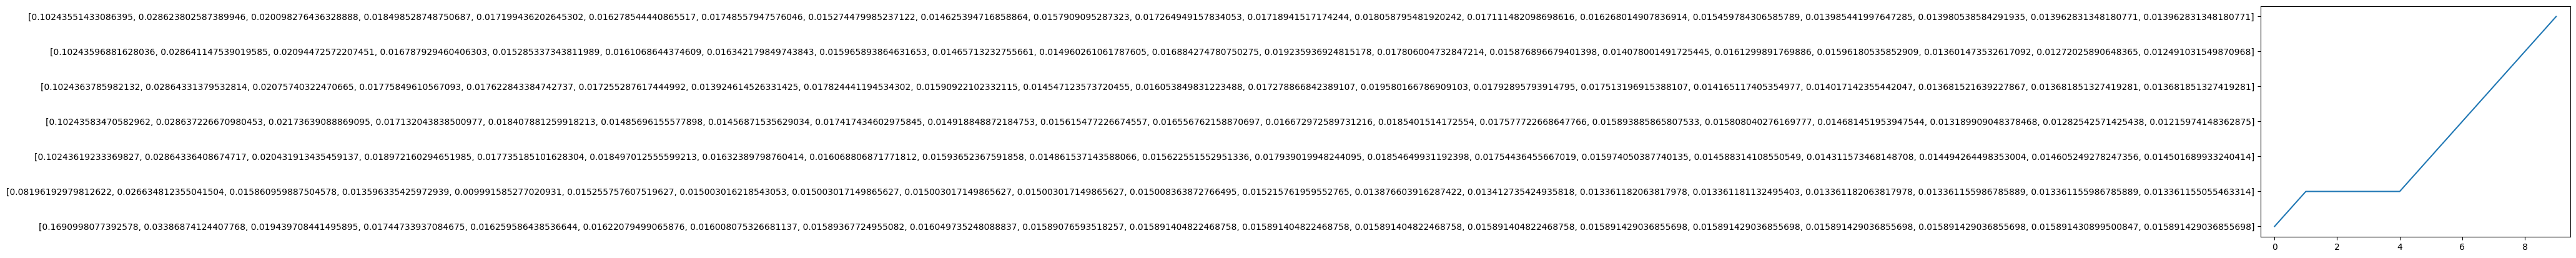

In [22]:
plt.plot(np.array(data['loss_train_history_before_prune']))
plt.show()

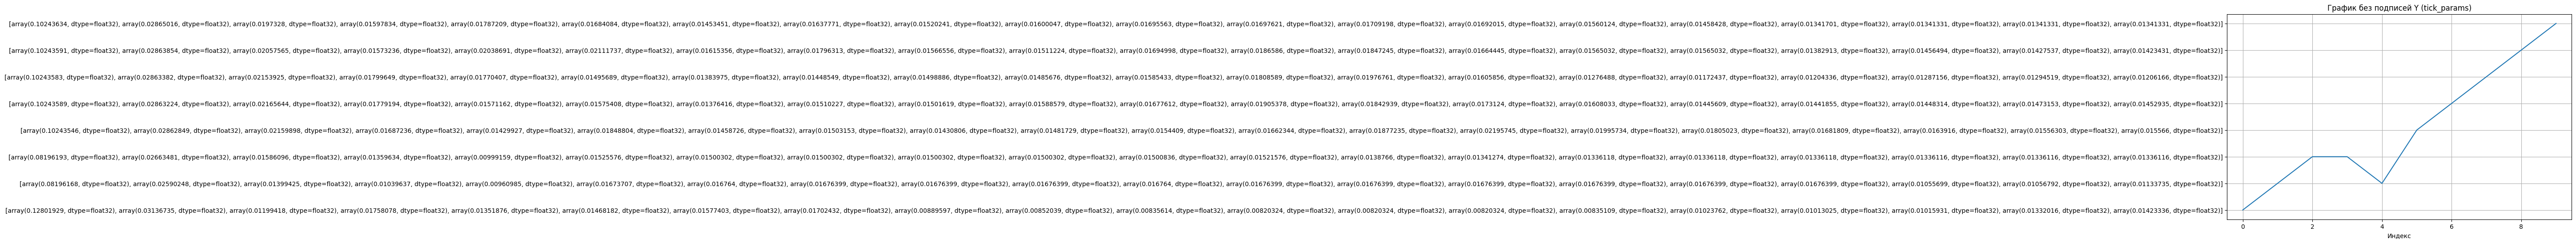

In [11]:
# Строим график
graph = list(data['loss_train_history_before_prune'])
plt.figure(figsize=(10, 6))
plt.plot(graph)
plt.title("График без подписей Y (tick_params)")
plt.xlabel("Индекс")
plt.grid(True)
plt.show()


In [15]:
np.array(data['loss_train_history_before_prune'][0])

array('[array(0.12801929, dtype=float32), array(0.03136735, dtype=float32), array(0.01199418, dtype=float32), array(0.01758078, dtype=float32), array(0.01351876, dtype=float32), array(0.01468182, dtype=float32), array(0.01577403, dtype=float32), array(0.01702432, dtype=float32), array(0.00889597, dtype=float32), array(0.00852039, dtype=float32), array(0.00835614, dtype=float32), array(0.00820324, dtype=float32), array(0.00820324, dtype=float32), array(0.00820324, dtype=float32), array(0.00835109, dtype=float32), array(0.01023762, dtype=float32), array(0.01013025, dtype=float32), array(0.01015931, dtype=float32), array(0.01332016, dtype=float32), array(0.01423336, dtype=float32)]',
      dtype='<U680')